In [1]:
# # Run this and then restart the kernel at the start of each session to install
# # 'teotil3' in development mode
# !pip install -e /home/jovyan/projects/teotil3/

In [2]:
import os
import warnings

import altair as alt
import matplotlib.pyplot as plt
import nivapy3 as nivapy
import numpy as np
import pandas as pd
import seaborn as sn
import statsmodels.formula.api as smf
import teotil3 as teo
from tqdm.notebook import tqdm

warnings.filterwarnings("ignore", category=FutureWarning)
plt.style.use("ggplot")

# TEOTIL3 Trondheimsfjorden

# Part 1: Evaluate runoff simulations

Before applying TEOTIL3 for the area around Trondheimsfjorden, I want to check that the model's simulations of water discharge (based on NVE's modelling) are reasonable.

## 1. Generate input files

In [3]:
eng = nivapy.da.connect_postgis()

Connection successful.


In [4]:
# Model settings
nve_data_year = 2024
st_yr, end_yr = 2013, 2023
agri_loss_model = "annual"  # 'annual' or 'risk'
model_input_csv_fold = (
    f"/home/jovyan/shared/common/teotil3/annual_input_data/agri_{agri_loss_model}_loss"
)
model_output_csv_fold = r"/home/jovyan/shared/common/teotil3/evaluation"

In [5]:
# # Generate model input files and save to disk
# years = range(st_yr, end_yr + 1)
# for year in tqdm(years):
#     gdf = teo.io.make_input_file(
#         year,
#         nve_data_year,
#         eng,
#         out_csv_fold=model_input_csv_fold,
#         nan_to_vass=True,
#         add_offshore=True,
#         order_coastal=False,  # Recommend False, except for comparison with TEOTIL2
#         land_to_vass=True,  # Recommend True, except for comparison with TEOTIL2
#         agri_loss_model=agri_loss_model,
#     )

## 2. Run model

In [6]:
# # Run TEOTIL3
# years = range(st_yr, end_yr + 1)
# df_list = []
# for year in tqdm(years):
#     csv_path = os.path.join(
#         model_input_csv_fold,
#         f"teotil3_input_data_nve{nve_data_year}_{year}.csv",
#     )
#     g = teo.model.run_model(
#         csv_path,
#         id_col="regine",
#         next_down_col="regine_down",
#         totals_from_subfracs=True,
#     )
#     res_df = teo.model.model_to_dataframe(
#         g, id_col="regine", next_down_col="regine_down"
#     )
#     res_df["year"] = year
#     df_list.append(res_df)
# mod_df = pd.concat(df_list, axis="rows")

# mod_csv = os.path.join(
#     model_output_csv_fold,
#     f"teo3_results_nve{nve_data_year}_{st_yr}-{end_yr}_agri-{agri_loss_model}-loss.csv",
# )
# mod_df.to_csv(mod_csv, index=False)

In [7]:
# Read saved data for speed
mod_csv = os.path.join(
    model_output_csv_fold,
    f"teo3_results_nve{nve_data_year}_{st_yr}-{end_yr}_agri-{agri_loss_model}-loss.csv",
)
mod_df = pd.read_csv(mod_csv)
mod_df.head()

,regine,regine_down,accum_agriculture-background_din_kg,accum_agriculture-background_ss_kg,accum_agriculture-background_tdp_kg,accum_agriculture-background_toc_kg,accum_agriculture-background_ton_kg,accum_agriculture-background_totn_kg,accum_agriculture-background_totp_kg,accum_agriculture-background_tpp_kg,...,local_urban_tpp_kg,local_wood_din_kg,local_wood_ss_kg,local_wood_tdp_kg,local_wood_toc_kg,local_wood_ton_kg,local_wood_totn_kg,local_wood_totp_kg,local_wood_tpp_kg,year
0,001.10,001.,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,36.1,849.2,0.6,9938.9,186.2,222.3,5.4,4.8,2013
1,001.1A2B,001.1A2A,125.911370,0.752367,3.420677,6341.957245,69.787520,195.698890,3.609359,0.188682,...,5.6,1318.1,29798.4,23.9,384175.8,7138.8,8456.9,210.0,186.1,2013
2,001.1A4D,001.1A4C,15.917595,0.289332,0.117126,464.712744,6.729665,22.647261,0.149627,0.032501,...,0.0,237.2,5272.5,4.3,70016.3,1296.4,1533.6,38.2,33.9,2013
3,001.1M,001.1L,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,473.5,11104.0,8.8,142788.5,2641.6,3115.1,78.3,69.5,2013
4,001.21,001.,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,5.0,117.0,0.1,1386.1,25.9,30.9,0.8,0.7,2013


## 3. Get measured data

The code below uses NVE's HydAPI to download all discharge data within vassdragsområder 120 to 132 for the period of model simulations. Station-years with near-complete monitoring data (>360 measurements per year) are then used to calculate the mean observed annual discharge for each station. These values can be compared to results from TEOTIL3.

In [8]:
# Define stations, parameters and time period of interest
par_ids = [1001]  # Discharge
st_dt = f"{st_yr}-01-01"
end_dt = f"{end_yr}-12-31"

# Vassdragsområder draining to Trondheimsfjorden
vassoms = range(120, 133)

In [9]:
# Get all stations from HydAPI
stn_df = nivapy.da.get_nve_hydapi_stations()

# Filter to vassoms of interest
stn_df["vassom"] = stn_df["station_id"].str.split(".").str[0].astype(int)
stn_df = stn_df.query("vassom in @vassoms")

# Get all discharge data for period of interest from HydAPI
df_list = []
stn_ids = []
for stn_id in tqdm(list(stn_df["station_id"])):
    try:
        df = nivapy.da.query_nve_hydapi(
            [stn_id], par_ids, st_dt, end_dt, resolution=1440
        )
        df_list.append(df)
        stn_ids.append(stn_id)
    except:
        pass
obs_q_df = pd.concat(df_list, axis="rows")

# Remove timezone information
obs_q_df["datetime"] = obs_q_df["datetime"].dt.tz_localize(None)

print(len(stn_df), "NVE stations around Trondheimsfjorden.")
stn_df = stn_df.query("station_id in @stn_ids")
print(
    len(stn_df),
    f"NVE stations around Trondheimsfjorden with discharge data within {st_yr} to {end_yr}.",
)

# Map
nivapy.spatial.quickmap(
    stn_df, lat_col="latitude", lon_col="longitude", popup="station_id", cluster=True
)

  0%|          | 0/96 [00:00<?, ?it/s]

96 NVE stations around Trondheimsfjorden.
38 NVE stations around Trondheimsfjorden with discharge data within 2013 to 2023.


In [10]:
# Save raw
stn_df[
    [
        "station_id",
        "station_name",
        "latitude",
        "longitude",
        "drainageBasinArea",
        "regineNo",
        "specificDischarge",
    ]
].to_excel("../data/nve_hydapi_stations.xlsx", index=False)
obs_q_df[["station_id", "datetime", "value"]].to_excel(
    f"../data/nve_hydapi_raw_discharge_trondheimsfjorden_{st_yr}-{end_yr}.xlsx",
    index=False,
)

In [11]:
# Calculate annual mean flows
obs_q_df["year"] = obs_q_df["datetime"].dt.year
obs_q_df = obs_q_df[["station_id", "year", "value"]]
obs_q_df = obs_q_df.groupby(["station_id", "year"]).agg(["mean", "count"])
obs_q_df.columns = obs_q_df.columns.get_level_values(1)
obs_q_df.reset_index(inplace=True)

# Only keep station-years with near-complete data
obs_q_df = obs_q_df.query("count > 360")
del obs_q_df["count"]

obs_q_df.rename({"mean": "obs_q_m3ps"}, axis="columns", inplace=True)

# Join station details
obs_q_df = pd.merge(
    obs_q_df,
    stn_df[
        [
            "station_id",
            "station_name",
            "latitude",
            "longitude",
            "drainageBasinArea",
            "regineNo",
            "specificDischarge",
        ]
    ],
    how="left",
    on="station_id",
)
obs_q_df.rename({"regineNo": "regine"}, axis="columns", inplace=True)

# Save
obs_q_df.to_excel(
    f"../data/nve_hydapi_annual_discharge_trondheimsfjorden_{st_yr}-{end_yr}.xlsx",
    index=False,
)
obs_q_df.head()

,station_id,year,obs_q_m3ps,station_name,latitude,longitude,drainageBasinArea,regine,specificDischarge
0,121.10.0,2013,43.861259,Bjørset Dam,63.05501,9.663,2317.4,121.B41,21.52
1,121.10.0,2014,33.663042,Bjørset Dam,63.05501,9.663,2317.4,121.B41,21.52
2,121.10.0,2015,40.449058,Bjørset Dam,63.05501,9.663,2317.4,121.B41,21.52
3,121.10.0,2016,35.784368,Bjørset Dam,63.05501,9.663,2317.4,121.B41,21.52
4,121.10.0,2017,57.536807,Bjørset Dam,63.05501,9.663,2317.4,121.B41,21.52


In [12]:
# Read saved data for speed
obs_q_df = pd.read_excel(
    f"../data/nve_hydapi_annual_discharge_trondheimsfjorden_{st_yr}-{end_yr}.xlsx"
)

## 4. Compare to model results

In [13]:
# Join modelled and observed data series
comp_df = pd.merge(
    mod_df[["regine", "year", "accum_q_m3/s", "accum_upstr_area_km2"]],
    obs_q_df,
    how="inner",
    on=["regine", "year"],
)

comp_stn_df = comp_df[
    [
        "station_id",
        "station_name",
        "regine",
        "longitude",
        "latitude",
        "drainageBasinArea",
    ]
].drop_duplicates()

# Scale modelled values by ratio of upstream areas to allow for monitoring sites
# located e.g. in the middle of regines
comp_df["accum_q_m3/s"] = (
    comp_df["accum_q_m3/s"]
    * comp_df["drainageBasinArea"]
    / comp_df["accum_upstr_area_km2"]
)

comp_df.head()

,regine,year,accum_q_m3/s,accum_upstr_area_km2,station_id,obs_q_m3ps,station_name,latitude,longitude,drainageBasinArea,specificDischarge
0,122.B1Z,2013,1.474375,84.438175,122.16.0,2.195517,Gaua,63.10217,10.20299,80.49,24.02
1,122.CB,2013,4.745768,218.953709,122.14.0,5.347956,Lillebudal bru,62.82336,10.54863,168.11,28.95
2,123.1,2013,0.027966,24.637299,123.95.0,0.041455,Kobberdammen,63.42260,10.28154,1.02,22.06
3,123.2C,2013,0.188548,63.877913,123.28.0,0.124039,Hokfossen,63.32643,10.63803,8.06,27.56
4,123.2C,2013,0.080238,63.877913,123.29.0,0.088287,Svarttjørnbekken,63.32032,10.64944,3.43,27.72


### 4.1. Distribution of catchment areas for monitoring stations

Text(0, 0.5, 'Tetthet [-]')

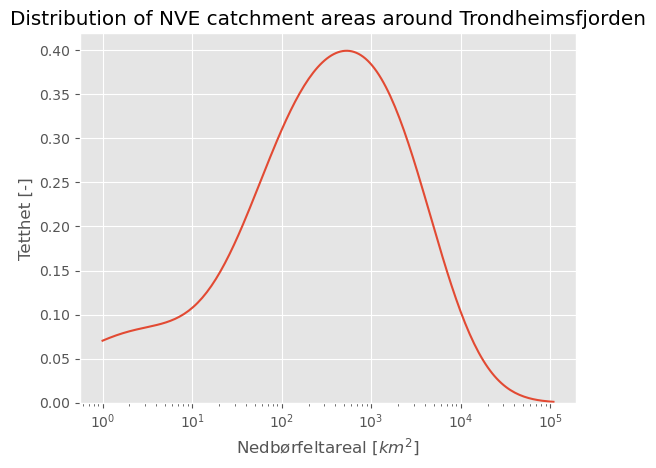

In [14]:
ax = sn.kdeplot(comp_stn_df, x="drainageBasinArea", clip=(0, None), log_scale=True)
ax.set_title("Distribution of NVE catchment areas around Trondheimsfjorden")
ax.set_xlabel("Nedbørfeltareal [$km^2$]")
ax.set_ylabel("Tetthet [-]")

### 4.2. Plot modelled versus observed

Mouse-hover on points on the plot below to see station details.

In [15]:
def create_chart(comp_df, log_scale=False):
    scatter = (
        alt.Chart(comp_df)
        .mark_circle(size=60)
        .encode(
            x=alt.X(
                "obs_q_m3ps",
                title="NVE målt (m3/s)",
                scale=alt.Scale(type="log" if log_scale else "linear"),
            ),
            y=alt.Y(
                "accum_q_m3/s",
                title="TEOTIL3 modellert (m3/s)",
                scale=alt.Scale(type="log" if log_scale else "linear"),
            ),
            tooltip=["station_id", "station_name", "regine", "year"],
        )
        .properties(width=600, height=400)
    )

    line = (
        alt.Chart(comp_df)
        .mark_line(color="black")
        .encode(x="obs_q_m3ps", y="obs_q_m3ps")
    )

    return alt.layer(scatter, line).interactive()


print("Number of unique stations with data:", len(comp_df["station_id"].unique()))
print("Number of station-years to compare:", len(comp_df))
create_chart(comp_df, log_scale=False)

Number of unique stations with data: 38
Number of station-years to compare: 370


alt.LayerChart(...)

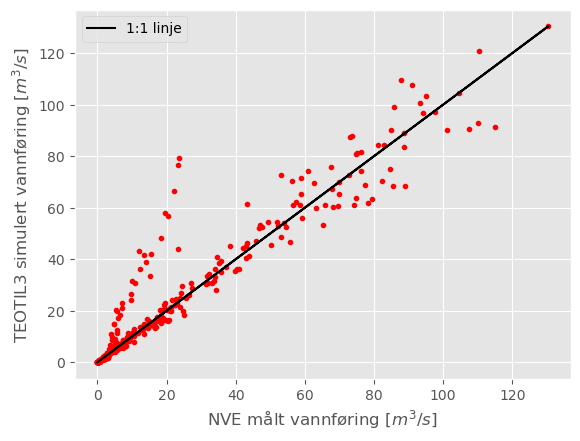

In [16]:
# Plot
plt.plot(comp_df["obs_q_m3ps"], comp_df["accum_q_m3/s"], "ro", markersize=3)
plt.plot(comp_df["obs_q_m3ps"], comp_df["obs_q_m3ps"], "k-", label="1:1 linje")
plt.xlabel("NVE målt vannføring [$m^3/s$]")
plt.ylabel("TEOTIL3 simulert vannføring [$m^3/s$]")
plt.legend()
plt.savefig(r"../results/images/flow_eval_with_hydro.png", dpi=200, bbox_inches="tight")

The model perform fairly well, except for three stations along Orklavassdraget: Storsteinhølen (121.39.0), Brattset (121.23.0) and Kvikne (121.25.0). According to NVE's Sildre website, these are all heavily regulated for hydropower. NVE's modelling does not include water transfers for hydropower or drinking water supply, so it is perhaps not surprising that the model performs poorly in these areas. According to the NVE website:

 * 100% of the catchment above [Storsteinhølen (121.39.0)](https://sildre.nve.no/station/121.39.0) is regulated for hydropower (the intake for the large Svorkmo kraftverk is just upstream of the monitoring station).
 * 75% of the catchment above [Brattset (121.23.0)](https://sildre.nve.no/station/121.23.0) is regulated for hydropower.
 * 61% of the catchment above [Kvikne (121.25.0)](https://sildre.nve.no/station/121.25.0) is regulated for hydropower.

These figures reflect the model's performance, with Storsteinhølen simulated worse than Brattset, which is worse than Kvikne. Overall, it looks like **more than 50% of the expected natural flow in the lower Orklavassgraget is diverted for hydropower**. Note that simulations for [Syrstad (121.22.0)](https://sildre.nve.no/station/121.22.0), just upstream from Storsteinhølen and the Svorkmo intake, are not too bad (see table below). Despite being a long way upstream, Syrstad is also the station used for flux calculations within Elveovervåkingsprogrammet - presumably to minimise the influence of flow regulation.

In [17]:
# Results for Syrstad
comp_df.query("station_id == '121.22.0'")

,regine,year,accum_q_m3/s,accum_upstr_area_km2,station_id,obs_q_m3ps,station_name,latitude,longitude,drainageBasinArea,specificDischarge
27,121.B421,2013,40.427746,2074.278515,121.22.0,43.111123,Syrstad,63.03225,9.72771,2278.34,21.4
62,121.B421,2014,30.788441,2074.278515,121.22.0,33.087322,Syrstad,63.03225,9.72771,2278.34,21.4
96,121.B421,2015,35.533227,2074.278515,121.22.0,39.757281,Syrstad,63.03225,9.72771,2278.34,21.4
129,121.B421,2016,38.574712,2074.278515,121.22.0,35.172368,Syrstad,63.03225,9.72771,2278.34,21.4
162,121.B421,2017,60.910288,2074.278515,121.22.0,56.552786,Syrstad,63.03225,9.72771,2278.34,21.4
196,121.B421,2018,44.408867,2074.278515,121.22.0,42.145817,Syrstad,63.03225,9.72771,2278.34,21.4
230,121.B421,2019,53.239324,2074.278515,121.22.0,47.068062,Syrstad,63.03225,9.72771,2278.34,21.4
264,121.B421,2020,70.193271,2074.278515,121.22.0,56.375130,Syrstad,63.03225,9.72771,2278.34,21.4
297,121.B421,2021,52.115427,2074.278515,121.22.0,46.859820,Syrstad,63.03225,9.72771,2278.34,21.4
331,121.B421,2022,72.582019,2074.278515,121.22.0,53.175375,Syrstad,63.03225,9.72771,2278.34,21.4


Overall, the model is able to accurately reproduce observed annual discharges. However, we need to be careful when applying TEOTIL3 in areas with lots of water transfers due to e.g. hydropower generation. During the rest of this project, **we should use services like Sildre and NVE Atlas to check whether the catchments and water bodies of interest are affected by such transfers**. In particular, **it is probably not appropriate to use TEOTIL3 to model the lower part of Orklavassdraget (downstream of the Svorkmo intake), without first adjusting runoff estimates to account for water transfers**.

                            OLS Regression Results                            
Dep. Variable:      Q('accum_q_m3/s')   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                 1.144e+04
Date:                Thu, 20 Feb 2025   Prob (F-statistic):          8.71e-255
Time:                        09:27:19   Log-Likelihood:                -973.72
No. Observations:                 326   AIC:                             1951.
Df Residuals:                     324   BIC:                             1959.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2873      0.341      0.842      0.4

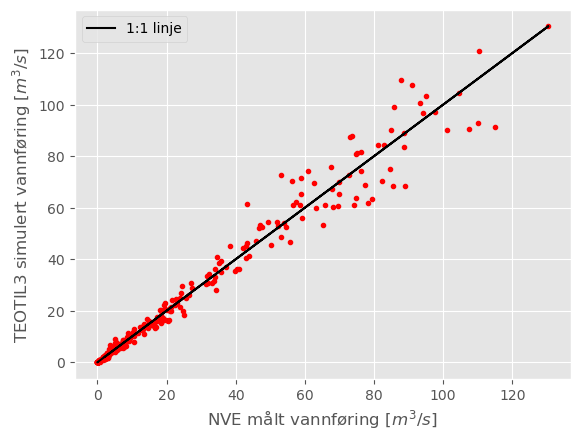

In [18]:
# Model performance excluding sites strongly affected by hydropower
excl_list = ["121.39.0", "121.23.0", "121.25.0"]
comp_df = comp_df.query("station_id not in @excl_list")

# Fit simple OLS model
model = smf.ols(formula="Q('accum_q_m3/s') ~ obs_q_m3ps", data=comp_df).fit()
print(model.summary())

# Plot
plt.plot(comp_df["obs_q_m3ps"], comp_df["accum_q_m3/s"], "ro", markersize=3)
plt.plot(comp_df["obs_q_m3ps"], comp_df["obs_q_m3ps"], "k-", label="1:1 linje")
plt.xlabel("NVE målt vannføring [$m^3/s$]")
plt.ylabel("TEOTIL3 simulert vannføring [$m^3/s$]")
plt.legend()
plt.savefig (r"../results/images/flow_eval_without_hydro.png", dpi=200, bbox_inches='tight')

Excluding sites obviously strongly affected by hydropower gives a best fit line with a gradient of 0.99, an intercept that is not significantly different from zero, and an R2 value of 97%. These statistics will be biased-good, because some of this monitoring data will have been used by NVE to calibrate their hydrological model. However, as a test of TEOTIL3, this notebook provides a clear demonstration that the model in capable to representing interannual variations in water discharge in areas where water transfers are not too great. In other words, the model is working as intended.